In [1]:
#include <TFile.h>
#include <TTree.h>
#include <TH1D.h>
#include <TEfficiency.h>
#include <TGraphErrors.h>
#include <TString.h>
#include <map>
#include <iostream>

In [2]:
gROOT->SetStyle("ATLAS");

In [3]:
using namespace std;

# Efficiency Plots

Reconstructed data was used to get the efficiency plots.

In [4]:
class anaOne
{
    public:
    TFile* file;
    TTree* tree;
    TH1D* ahist;
    TH1D* phist;
    TH1D* dhist;
    TEfficiency* effi;
    int nevent;
    int det_id;
    int detectorID;
    int elementID_exp;
    int elementID_closest;
    double voltage;
    
    anaOne(TString file_name, double vol);
    void ana(int id);
};

In [5]:
anaOne::anaOne(TString file_name, double vol)
{
    file = TFile::Open(file_name.Data(), "READ");
    tree = (TTree*)file->Get("save");
    nevent = tree->GetEntries();
    
    tree->SetBranchAddress("detectorID", &detectorID);
    tree->SetBranchAddress("elementID_exp", &elementID_exp);
    tree->SetBranchAddress("elementID_closest", &elementID_closest);
    
    voltage = vol;
}

In [6]:
void anaOne::ana(int id)
{
    det_id = id;
    TString aname = Form("ahist_%d_%f", det_id, voltage);
    TString atitle = Form("; element_id [det_id = %d]; counts", det_id);
    ahist = new TH1D(aname.Data(), atitle.Data(), 16, 0.5, 16.5);
    
    TString pname = Form("phist_%d_%f", det_id, voltage);
    TString ptitle = Form("; element_id [det_id = %d]; counts", det_id);
    phist = new TH1D(pname.Data(), ptitle.Data(), 16, 0.5, 16.5);
    
    TString dname = Form("dhist_%d_%f", det_id, voltage);
    TString dtitle = Form("; pad_diff [det_id = %d]; counts", det_id);
    dhist = new TH1D(dname.Data(), dtitle.Data(), 20, -10.0, 10.0);
    
    for(int i = 0; i < nevent; i++)
    {
        tree->GetEntry(i);
        if(detectorID == det_id)
        {
            if(elementID_closest > 0)
            {
                ahist->Fill(elementID_exp);
                if(abs(elementID_exp - elementID_closest) < 3){phist->Fill(elementID_exp);}
                dhist->Fill(elementID_exp - elementID_closest);
            }
        }
    }
    
    TString ename = Form("effi_%d_%f", det_id, voltage);
    TString etitle = Form("; elemet_id [det_id = %d]; efficiency", det_id);
    effi = new TEfficiency(*phist, *ahist);
    effi->SetName(ename.Data());
    effi->SetTitle(etitle.Data());
    effi->SetMarkerColor(2);
    
    dhist->SetFillColor(kAzure+10);
}

In [7]:
class anaBook
{
    public:
    anaOne* A0;
    anaOne* A50;
    
    int det_id;
    int ele_id;
    
    TGraphErrors* g;
    TCanvas* can;
    
    anaBook(anaOne* a, anaOne* b);
    void plot(int det, int ele);
};

In [8]:
anaBook::anaBook(anaOne* a, anaOne* b)
{
    A0 = a;
    A50 = b;
}

In [9]:
void anaBook::plot(int det, int ele)
{
    det_id = det;
    ele_id = ele;
    
    g = new TGraphErrors();
    g->SetMarkerColor(4);
    TString gname = Form("g_%d_%d", det_id, ele_id);
    TString gtitle = Form("; voltage [det_id = %d, ele_id = %d]; efficiency", det_id, ele_id);
    g->SetNameTitle(gname.Data(), gtitle.Data());
    
    A0->ana(det_id);
    g->SetPoint(0, A0->voltage, A0->effi->GetEfficiency(ele_id));
    g->SetPointError(0, 0.0, A0->effi->GetEfficiencyErrorUp(ele_id));
    
    A50->ana(det_id);
    g->SetPoint(1, A50->voltage, A50->effi->GetEfficiency(ele_id));
    g->SetPointError(1, 0.0, A50->effi->GetEfficiencyErrorUp(ele_id));
    
    TString cname_0 = Form("can_%d_%f", det_id, A0->voltage);
    can = new TCanvas(cname_0.Data(), cname_0.Data(), 1000, 500);
    can->Divide(2);
    
    can->cd(1);
    A0->effi->Draw("P0");
    
    can->cd(2);
    A0->dhist->Draw();
    
    TString save0 = Form("can_%d_%f.png", det_id, A0->voltage);
    can->Print(save0.Data());
    can->Draw();
    
    TString cname_50 = Form("can_%d_%f", det_id, A50->voltage);
    can = new TCanvas(cname_50.Data(), cname_50.Data(), 1000, 500);
    can->Divide(2);
    
    can->cd(1);
    A50->effi->Draw("P0");
    
    can->cd(2);
    A50->dhist->Draw();
    
    TString save50 = Form("can_%d_%f.png", det_id, A50->voltage);
    can->Print(save50.Data());
    can->Draw();
    
    TString cname_g = Form("can_g_%d_%d", det_id, ele_id);
    can = new TCanvas(cname_g.Data(), cname_50.Data(), 500, 500);
    g->Draw("AP");
    TString saveg = Form("can_%d_%d.png", det_id, ele_id);
    can->Print(saveg.Data());
    can->Draw();
    
}

In [10]:
map<string, int> det {
    {"H4Y1R", 42},
    {"H4Y2R", 44},
    {"H4B", 45}
};

## Nominal Voltage

In [11]:
anaOne* A = new anaOne("nominal/ana.root", 0.0);
anaOne* B = new anaOne("up50/ana.root", 50.0);
anaBook* C = new anaBook(A, B);

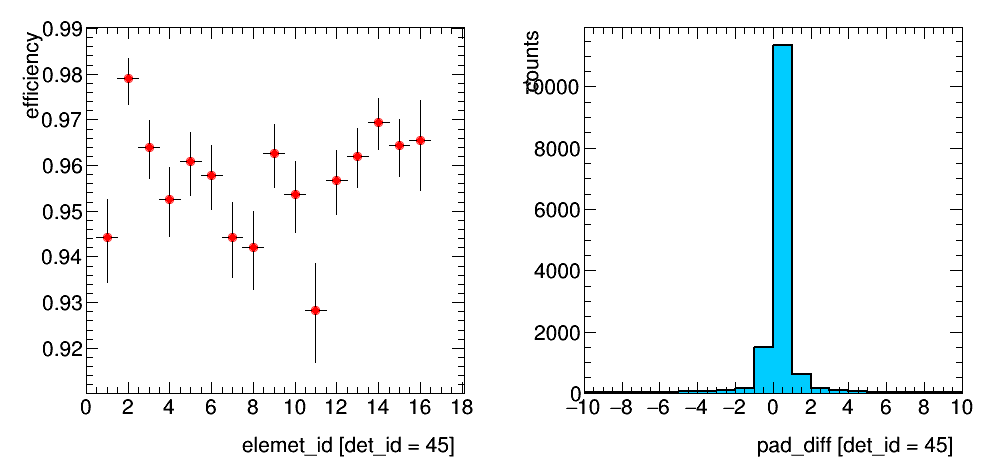

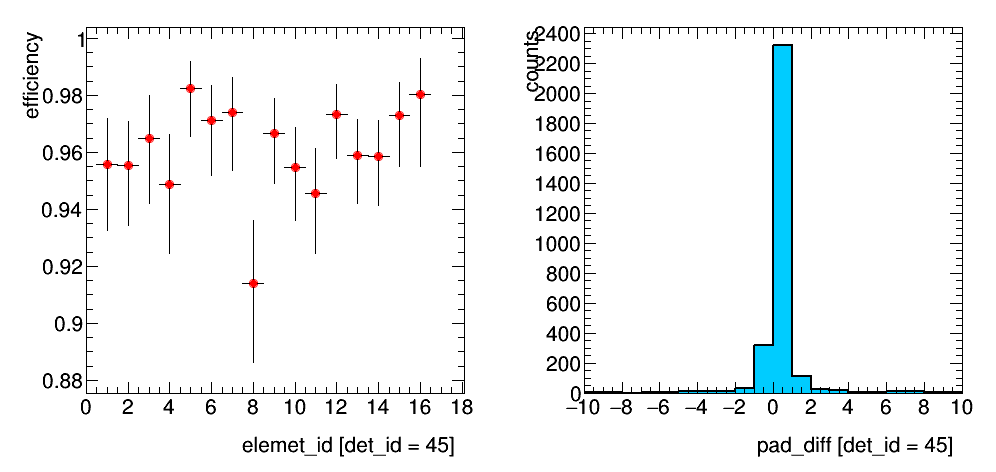

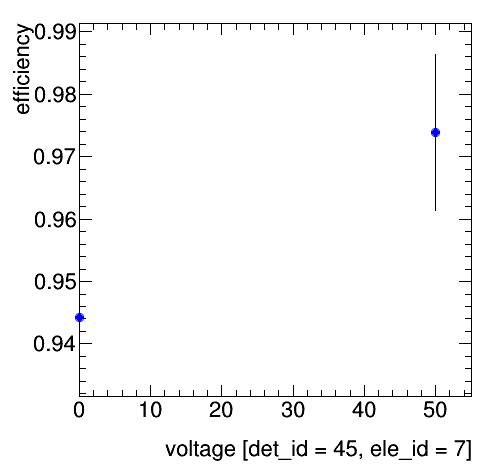

Info in <TCanvas::Print>: png file can_45_0.000000.png has been created
Info in <TCanvas::Print>: png file can_45_50.000000.png has been created
Info in <TCanvas::Print>: png file can_45_7.png has been created


In [12]:
C->plot(det["H4B"], 7);

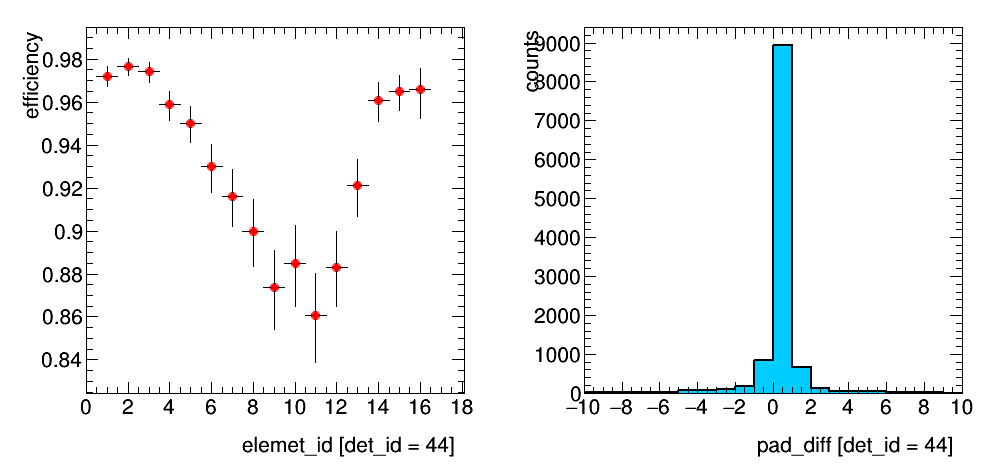

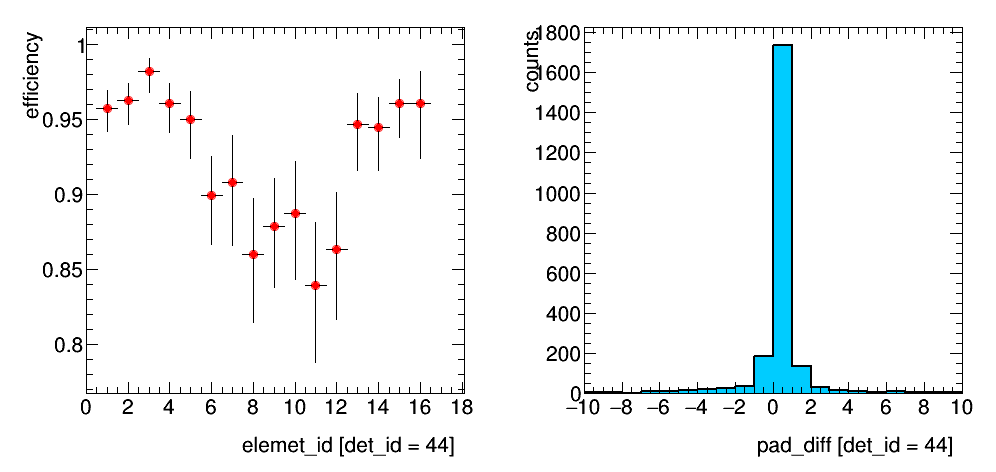

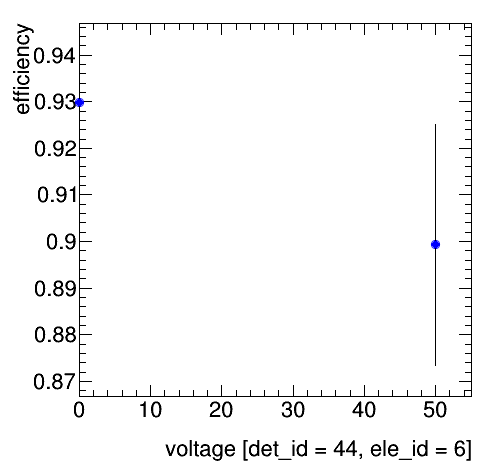

Info in <TCanvas::Print>: png file can_44_0.000000.png has been created
Info in <TCanvas::Print>: png file can_44_50.000000.png has been created
Info in <TCanvas::Print>: png file can_44_6.png has been created


In [13]:
C->plot(det["H4Y2R"], 6)

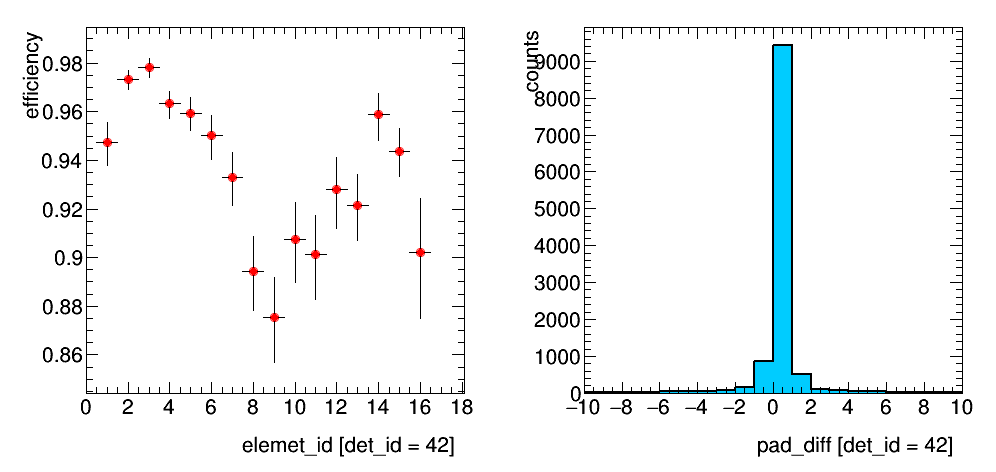

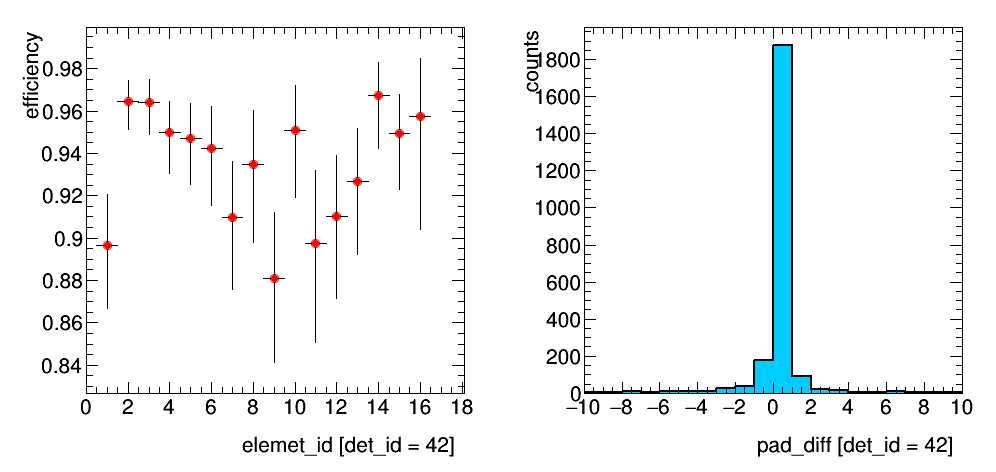

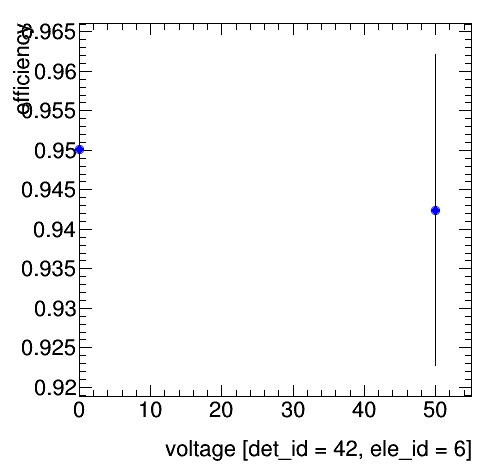

Info in <TCanvas::Print>: png file can_42_0.000000.png has been created
Info in <TCanvas::Print>: png file can_42_50.000000.png has been created
Info in <TCanvas::Print>: png file can_42_6.png has been created


In [14]:
C->plot(det["H4Y1R"], 6)

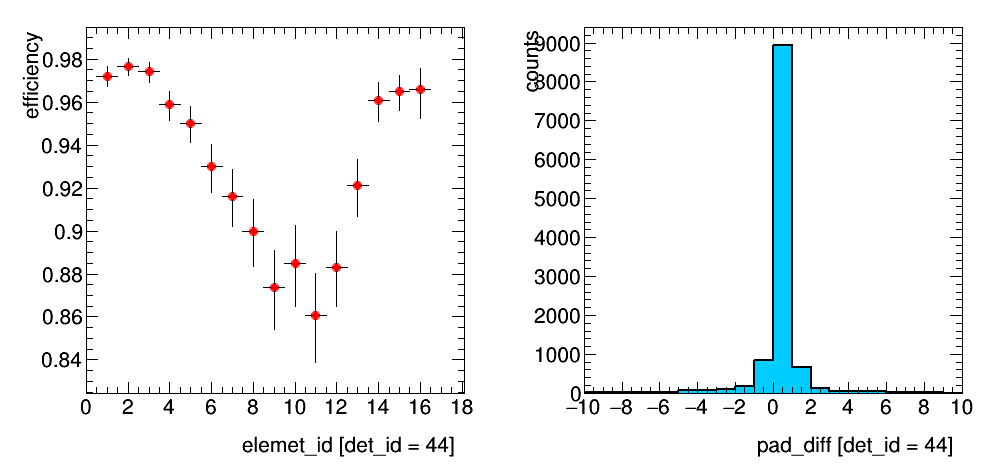

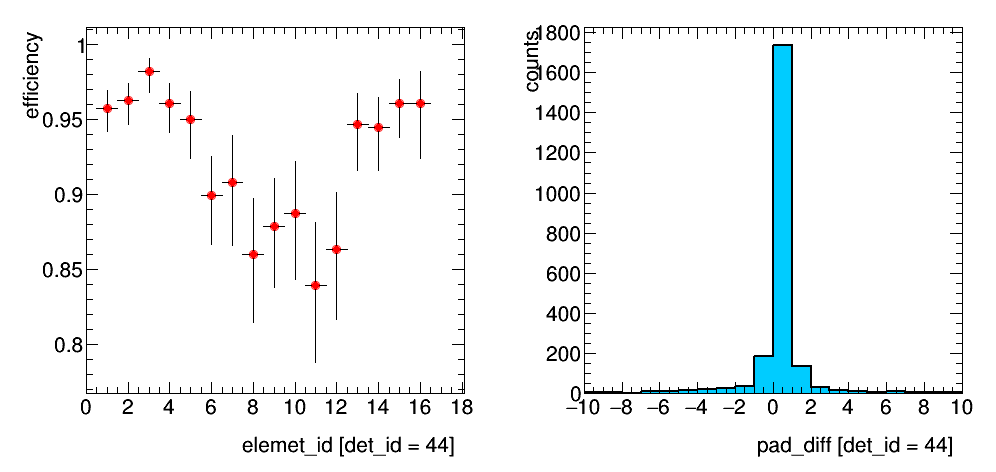

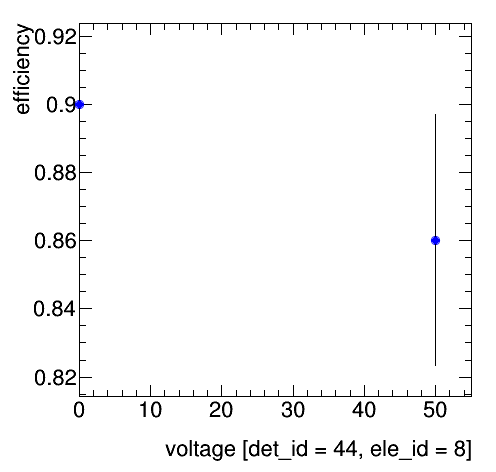

Warning in <TFile::Append>: Replacing existing TH1: ahist_44_0.000000 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: phist_44_0.000000 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: dhist_44_0.000000 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ahist_44_50.000000 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: phist_44_50.000000 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: dhist_44_50.000000 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_44_0.000000
Info in <TCanvas::Print>: png file can_44_0.000000.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_44_50.000000
Info in <TCanvas::Print>: png file can_44_50.000000.png has been created
Info in <TCanvas::Print>: png file can_44_8.png has been created


In [15]:
C->plot(det["H4Y2R"], 8)